In [10]:
import zipfile

z= zipfile.ZipFile('data/malaria.zip')
z.extractall()

In [11]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')


In [12]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm, tqdm_notebook
import cv2
from scipy import stats
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, precision_score, recall_score
from sklearn.linear_model import LinearRegression

import skimage
import skimage.segmentation
import copy
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
import matplotlib.image as mpimg

# %tensorflow_version 2.x  # Only needed in Google Colab
import tensorflow as tf

# Check GPU availability
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print('GPU device not found, using CPU instead.')
    tf.config.set_visible_devices([], 'GPU')
else:
    print(f'Found GPU at: {physical_devices[0]}')

print('TensorFlow version:', tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Flatten, Dense, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.imagenet_utils import decode_predictions


GPU device not found, using CPU instead.
TensorFlow version: 2.17.0


In [13]:
original_dataset_parasitized = os.path.join('cell_images/cell_images', 'Parasitized/')
original_dataset_uninfected = os.path.join('cell_images/cell_images', 'Uninfected/')

In [14]:
# Create a base dir
if not os.path.isdir('healthy_and_infected'):
    base_dir = 'healthy_and_infected'
    os.mkdir(base_dir)

In [15]:
# Make train, valid and test directories
#train
if not os.path.isdir('healthy_and_infected/train'):
    train_dir = os.path.join(base_dir, 'train')
    os.mkdir(train_dir)
#valid
if not os.path.isdir('healthy_and_infected/valid'):
    valid_dir = os.path.join(base_dir, 'valid')
    os.mkdir(valid_dir)
#test
if not os.path.isdir('healthy_and_infected/test'):
    test_dir = os.path.join(base_dir, 'test')
    os.mkdir(test_dir)

In [16]:
# Make directories for infected images in each of the train, valid and test directories
if not os.path.isdir('healthy_and_infected/train/inf'):
    infected_trn_dir = os.path.join(train_dir, 'inf')
    os.mkdir(infected_trn_dir)

if not os.path.isdir('healthy_and_infected/valid/inf'):
    infected_valid_dir = os.path.join(valid_dir, 'inf')
    os.mkdir(infected_valid_dir)

if not os.path.isdir('healthy_and_infected/test/inf'):
    infected_test_dir = os.path.join(test_dir, 'inf')
    os.mkdir(infected_test_dir)

In [17]:
# Make directories for healthy images in each of the train, valid and test directories
if not os.path.isdir('healthy_and_infected/train/healthy'):
    healthy_trn_dir = os.path.join(train_dir, 'healthy')
    os.mkdir(healthy_trn_dir)

if not os.path.isdir('healthy_and_infected/valid/healthy'):
    healthy_valid_dir = os.path.join(valid_dir, 'healthy')
    os.mkdir(healthy_valid_dir)

if not os.path.isdir('healthy_and_infected/test/healthy'):
    healthy_test_dir = os.path.join(test_dir, 'healthy')
    os.mkdir(healthy_test_dir)

In [18]:
files1 = os.listdir('cell_images/cell_images/Parasitized/')
fnames1 = []
for i in range(13779):
    fnames1.append(files1[i])

if 'Thumbs.db' in fnames1:
    os.remove('cell_images/cell_images/Parasitized/Thumbs.db')

files2 = os.listdir('cell_images/cell_images/Uninfected/')
fnames2 = []
for i in range(13779):
    fnames2.append(files2[i])

if 'Thumbs.db' in fnames2:
    os.remove('cell_images/cell_images/Uninfected/Thumbs.db')

In [19]:
files = os.listdir('cell_images/cell_images/Parasitized/')
fnames = []
for i in range(11023):
    fnames.append(files[i])
  
for fname in fnames:
    src = os.path.join(original_dataset_parasitized, fname)
    dst = os.path.join(infected_trn_dir, fname)
    shutil.copyfile(src,dst)

In [20]:
files = os.listdir('cell_images/cell_images/Parasitized/')
fnames = []
for i in range(11023, 12401):
    fnames.append(files[i])
    
for fname in fnames:
    src = os.path.join(original_dataset_parasitized, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src,dst)

In [21]:
files = os.listdir('cell_images/cell_images/Parasitized/')
fnames = []
for i in range(12401, 13779):
    fnames.append(files[i])
    
for fname in fnames:
    src = os.path.join(original_dataset_parasitized, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src,dst)

In [22]:
files = os.listdir('cell_images/cell_images/Uninfected/')
fnames = []
for i in range(11023):
    fnames.append(files[i])
    
for fname in fnames:
    src = os.path.join(original_dataset_uninfected, fname)
    dst = os.path.join(healthy_trn_dir, fname)
    shutil.copyfile(src,dst)

In [23]:
files = os.listdir('cell_images/cell_images/Uninfected/')
fnames = []
for i in range(11023, 12401):
    fnames.append(files[i])
    
for fname in fnames:
    src = os.path.join(original_dataset_uninfected, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src,dst)

In [24]:
files = os.listdir('cell_images/cell_images/Uninfected/')
fnames = []
for i in range(12401, 13779):
    fnames.append(files[i])
    
for fname in fnames:
    src = os.path.join(original_dataset_uninfected, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src,dst)

In [25]:
print("{} Infected training images:".format(len(os.listdir(infected_trn_dir))))
print("{} Uninfected training images:".format(len(os.listdir(healthy_trn_dir))))
print(" {} Infected valid images:".format(len(os.listdir(infected_valid_dir))))
print(" {} Uninfected valid images:".format(len(os.listdir(healthy_valid_dir))))
print(" {} Infected testing images:".format(len(os.listdir(infected_test_dir))))
print(" {} Uninfected testing images:".format(len(os.listdir(healthy_test_dir))))

11023 Infected training images:
11023 Uninfected training images:
 1378 Infected valid images:
 1378 Uninfected valid images:
 1378 Infected testing images:
 1378 Uninfected testing images:


# Exploratory Data Analysis

In [26]:
# Train
infected_trn_fpaths = [os.path.join(infected_trn_dir, fpath) for fpath in os.listdir(infected_trn_dir)]
healthy_trn_fpaths = [os.path.join(healthy_trn_dir, fpath) for fpath in os.listdir(healthy_trn_dir)]

# Valid
infected_valid_fpaths = [os.path.join(infected_valid_dir, fpath) for fpath in os.listdir(infected_valid_dir)]
healthy_valid_fpaths = [os.path.join(healthy_valid_dir, fpath) for fpath in os.listdir(healthy_valid_dir)]

# Test
infected_test_fpaths = [os.path.join(infected_test_dir, fpath) for fpath in os.listdir(infected_test_dir)]
healthy_test_fpaths = [os.path.join(healthy_test_dir, fpath) for fpath in os.listdir(healthy_test_dir)]

In [27]:
def get_img_shape(idx, img, total_num_images):
    
    if idx%2000 ==0 or idx == (total_num_images-1):
        print("working on img {}".format(idx))
    return cv2.imread(img).shape

data_inp = [(idx, img, len(infected_trn_fpaths + healthy_trn_fpaths)) for idx, img in enumerate(infected_trn_fpaths + healthy_trn_fpaths)]

train_img_dims_map = list(map(get_img_shape, [input[0] for input in data_inp],
    [input[1] for input in data_inp],
    [input[2] for input in data_inp]))

working on img 0
working on img 2000
working on img 4000
working on img 6000
working on img 8000
working on img 10000
working on img 12000
working on img 14000
working on img 16000
working on img 18000
working on img 20000
working on img 22000
working on img 22045


In [28]:
print('Min Dimensions:           {}'.format(np.min(train_img_dims_map, axis=0)))
print('Avg Dimensions:           {}'.format(np.mean(train_img_dims_map, axis=0)))
print('Median Dimensions:        {}'.format(np.median(train_img_dims_map, axis=0)))
print('Most Frequent Dimensions: {}'.format(stats.mode(train_img_dims_map, axis=0)[0]))
print('Max Dimensions:           {}'.format(np.max(train_img_dims_map, axis=0)))

Min Dimensions:           [40 46  3]
Avg Dimensions:           [132.07520639 131.60382836   3.        ]
Median Dimensions:        [130. 130.   3.]
Most Frequent Dimensions: [130 130   3]
Max Dimensions:           [346 265   3]


In [29]:
infected_trn_samples = random.sample(infected_trn_fpaths, 5)
healthy_trn_samples = random.sample(healthy_trn_fpaths, 5)

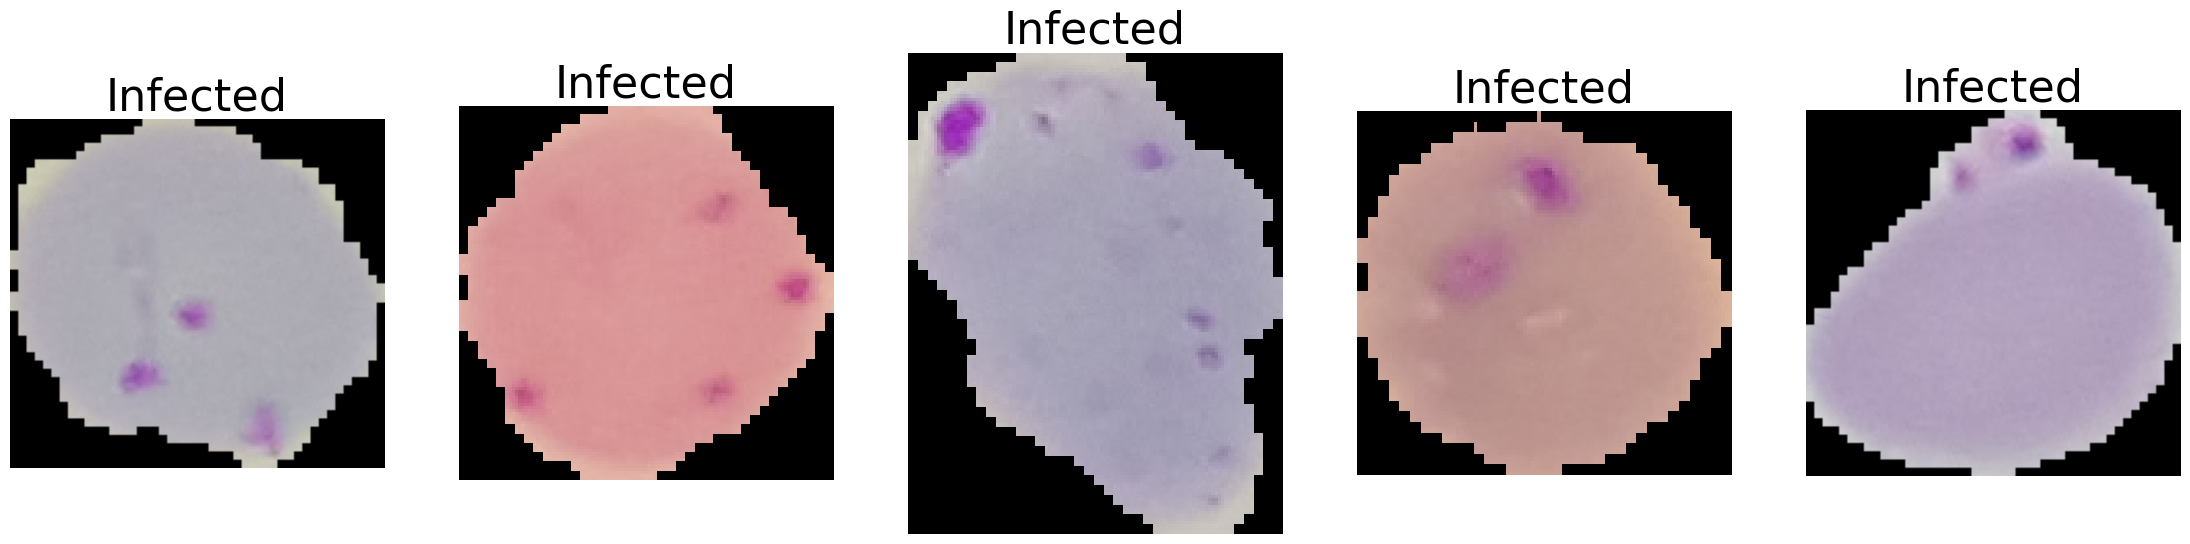

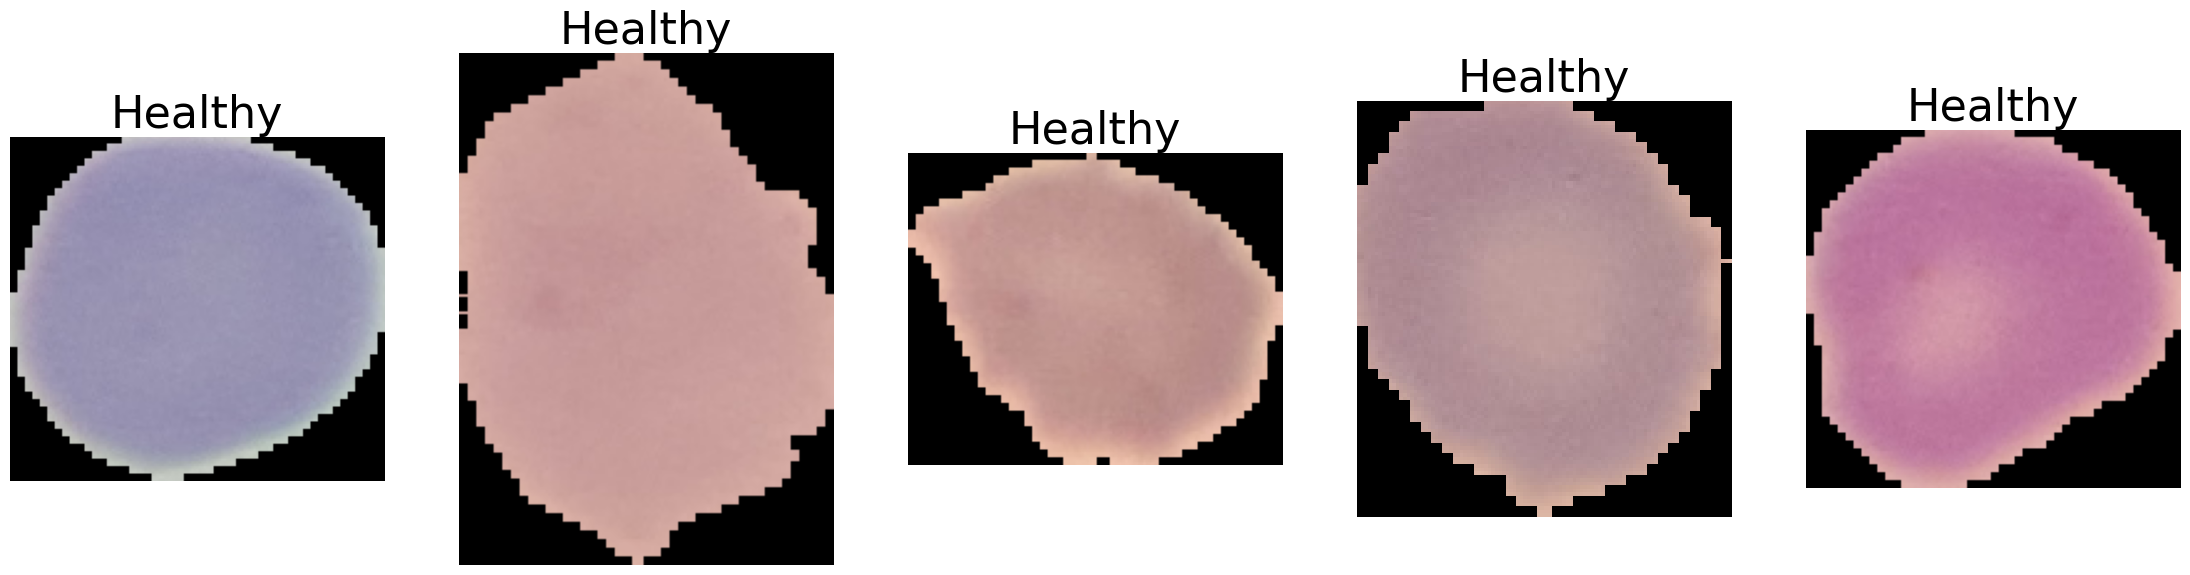

In [30]:
fig =plt.figure(figsize=(28,14))
columns=5
rows=1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(mpimg.imread(infected_trn_samples[i-1]))
    plt.axis('off')
    plt.title('Infected', fontsize=32)
plt.show()


fig =plt.figure(figsize=(28,14))
columns=5
rows=1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(mpimg.imread(healthy_trn_samples[i-1]))
    plt.axis('off')
    plt.title('Healthy', fontsize=32)
plt.savefig("outputs/malaria_cell_images.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

# Data augmentation and resizing images

In [31]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=0.4,
                                   vertical_flip=0.4,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    target_size=(128,128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    batch_size=32,
                                                    target_size=(128, 128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

class_labels = train_generator.class_indices
class_names = {value:key for (key, value) in class_labels.items()}

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


In [32]:
class_labels, class_names

({'healthy': 0, 'inf': 1}, {0: 'healthy', 1: 'inf'})

# Transfer Learning - VGG19 CNN Architecture

In [34]:
# Instantiate VGG19 model with weights from Imagenet without the calssifier at the top
base_model = VGG19(input_shape = (128,128,3),
                   include_top = False, 
                   weights = 'imagenet')
# Freeze the ConvNet to avoid weight updates
for layer in base_model.layers:
    layer.trainable=False
    
x = base_model.output
flat=Flatten()(x)

# Add a classifier -  a fully connected dense layers
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

# Bake a model
model_01 = Model(base_model.inputs, output)
model_01.summary()

# Callbacks
filepath = 'models/malaria.keras'  # Change .h5 to .keras
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)

# Define an optimizer
sgd = SGD(learning_rate=.0001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

C:\Users\divyam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [35]:
# Fit the model on the training set and train for 10 epochs
history_01 = model_01.fit(train_generator,
                          steps_per_epoch=50,
                          epochs=10,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/10


C:\Users\divyam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4975 - loss: 0.7479
Epoch 1: val_loss improved from inf to 0.64014, saving model to models/malaria.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 260s 5s/step - accuracy: 0.4981 - loss: 0.7471 - val_accuracy: 0.5711 - val_loss: 0.6401 - learning_rate: 1.0000e-04
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6410 - loss: 0.6404
Epoch 2: val_loss improved from 0.64014 to 0.58661, saving model to models/malaria.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 246s 5s/step - accuracy: 0.6410 - loss: 0.6402 - val_accuracy: 0.6814 - val_loss: 0.5866 - learning_rate: 1.0000e-04
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6562 - loss: 0.6108
Epoch 3: val_loss did not improve from 0.58661
50/50 ━━━━━━━━━━━━━━━━━━━━ 245s 5s/step - accuracy: 0.6565 - loss: 0.6106 - val_accuracy: 0.5160 - val_loss: 0.6477 - learning_rate: 1.0000e-04
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6936 - loss: 0.5887
Epoch 4: val_loss improved

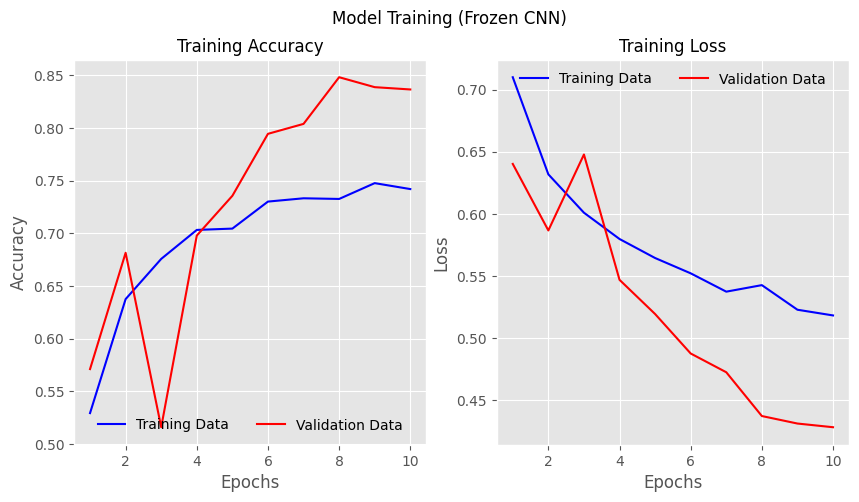

In [36]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("outputs/malaria_training_frozencnn.jpeg", format='jpeg', dpi=400, bbox_inches='tight')

In [43]:
# Save model weights
weights_dir = 'model_weights/'  # Directory for saving model weights
if not os.path.exists(weights_dir):  # Check if the directory exists
    os.mkdir(weights_dir)

# Save weights to the specified file
model_01.save_weights(filepath=os.path.join(weights_dir, 'vgg19_model_01.weights.h5'), overwrite=True)


In [44]:
# Resize test images similar to the train data
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  target_size=(128, 128),
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  seed=42,
                                                  color_mode='rgb')

Found 2756 images belonging to 2 classes.


In [46]:
# Load the saved model
model_01.load_weights('model_weights/vgg19_model_01.weights.h5')
# Evaluate the model on the hold out validation and test datasets

# Evaluate the model on batches of validation and testing data
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

print('Validation loss:     {0:.4f}'.format(vgg_val_eval_01[0]))
print('Validation accuracy: {0:.4f}'.format(vgg_val_eval_01[1]))
print('Test loss:           {0:.4f}'.format(vgg_test_eval_01[0]))
print('Test accuracy:       {0:.4f}'.format(vgg_test_eval_01[1]))

87/87 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.8466 - loss: 0.4247
   1/2756 ━━━━━━━━━━━━━━━━━━━━ 7:55 173ms/step - accuracy: 1.0000 - loss: 0.4921

C:\Users\divyam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2756/2756 ━━━━━━━━━━━━━━━━━━━━ 374s 136ms/step - accuracy: 0.8150 - loss: 0.4724
Validation loss:     0.4282
Validation accuracy: 0.8364
Test loss:           0.4640
Test accuracy:       0.8055


In [47]:
filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_01 = model_01.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_01= np.argmax(vgg_predictions_01, axis=1)

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 348s 126ms/step


In [48]:
# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_01, 
                            target_names=['healthy', 'infected']))
vgg_conf_mat_01 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_01), 
                        index=['healthy', 'infected'], 
                        columns=['healthy', 'infected'])

              precision    recall  f1-score   support

     healthy       0.79      0.84      0.81      1378
    infected       0.83      0.78      0.80      1378

    accuracy                           0.81      2756
   macro avg       0.81      0.81      0.81      2756
weighted avg       0.81      0.81      0.81      2756



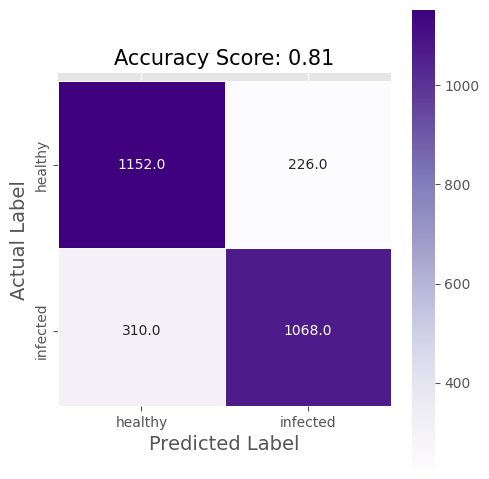

In [49]:
fig, ax = plt.subplots(figsize=(5,5))
#plt.figure(figsize=(9,9))
sns.heatmap(vgg_conf_mat_01, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_01[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_01)-0.05, -0.05)
plt.tight_layout()

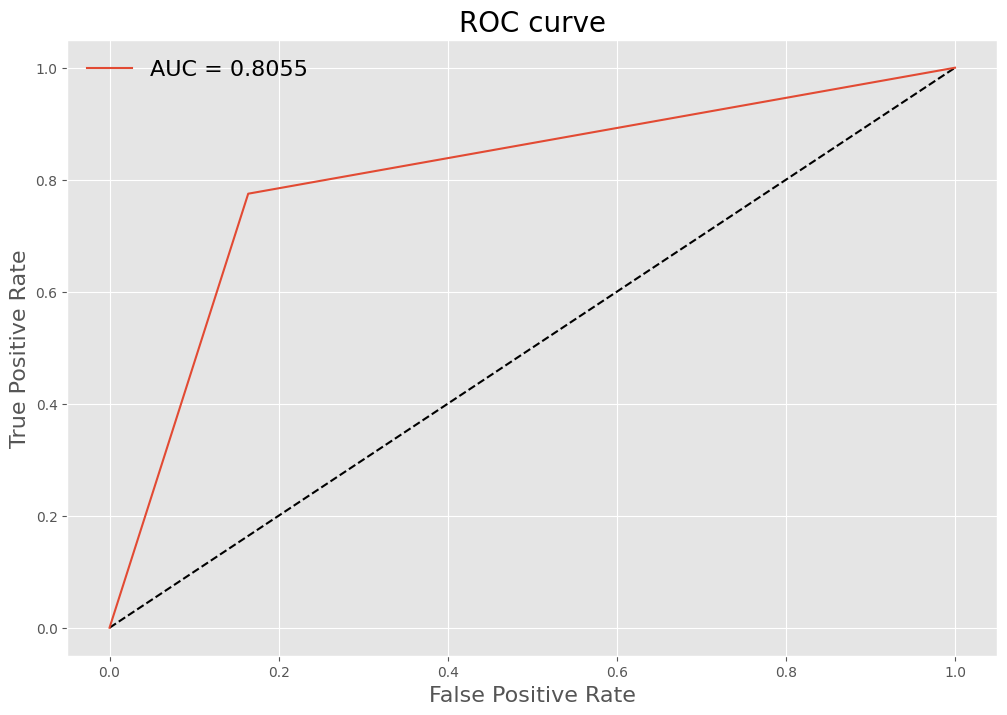

In [50]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_01)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.4f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

# Incremental unfreezing and fine-tuning

In [51]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output

flat=Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.weights.h5')

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv4', 'block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 47,784,834 (182.28 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

None


In [52]:
sgd = SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#model_02 = Model(base_model.inputs, output)
model_02.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

C:\Users\divyam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [53]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs=10, callbacks = [es, cp, lrr], validation_data = valid_generator)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6595 - loss: 0.6910
Epoch 1: val_loss did not improve from 0.42824
10/10 ━━━━━━━━━━━━━━━━━━━━ 156s 17s/step - accuracy: 0.6584 - loss: 0.6958 - val_accuracy: 0.7823 - val_loss: 0.4637 - learning_rate: 0.0010
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7725 - loss: 0.4937
Epoch 2: val_loss did not improve from 0.42824
10/10 ━━━━━━━━━━━━━━━━━━━━ 168s 18s/step - accuracy: 0.7719 - loss: 0.4935 - val_accuracy: 0.7812 - val_loss: 0.4439 - learning_rate: 0.0010
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7631 - loss: 0.4672
Epoch 3: val_loss improved from 0.42824 to 0.32409, saving model to models/malaria.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 160s 18s/step - accuracy: 0.7628 - loss: 0.4667 - val_accuracy: 0.8777 - val_loss: 0.3241 - learning_rate: 0.0010
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7807 - loss: 0.5066
Epoch 4: val_loss improved from 0.32409 to 0.31298, saving mod

In [54]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath='model_weights/vgg19_model_02.weights.h5', overwrite=True)

# Evaluating the model

87/87 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.8685 - loss: 0.2910
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 364s 132ms/step - accuracy: 0.9385 - loss: 0.1783
Validation loss:     0.2956900894641876
Validation accuracy: 0.8635703921318054
Test loss:           0.31859666109085083
Test accuracy:       0.8494194746017456
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 380s 138ms/step
              precision    recall  f1-score   support

     healthy       0.77      0.99      0.87      1378
    infected       0.98      0.71      0.82      1378

    accuracy                           0.85      2756
   macro avg       0.88      0.85      0.85      2756
weighted avg       0.88      0.85      0.85      2756



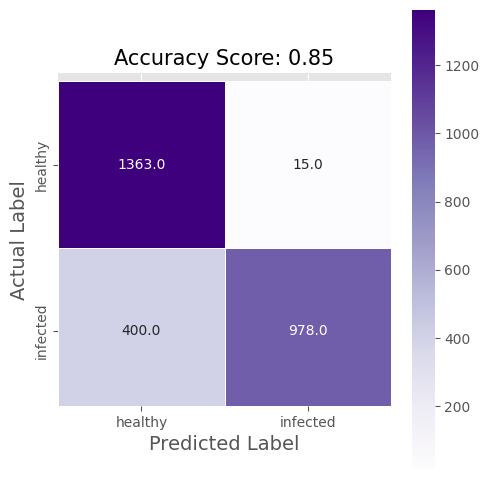

In [56]:
# Load the saved model
model_02.load_weights('model_weights/vgg19_model_02.weights.h5')
# Evaluate the model on the hold out validation and test datasets

vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print('Validation loss:     {}'.format(vgg_val_eval_02[0]))
print('Validation accuracy: {}'.format(vgg_val_eval_02[1]))
print('Test loss:           {}'.format(vgg_test_eval_02[0]))
print('Test accuracy:       {}'.format(vgg_test_eval_02[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_02 = model_02.predict(test_generator,
                                                steps = nb_samples,
                                                verbose=1)
vgg_pred_labels_02 = np.argmax(vgg_predictions_02, axis=1)


# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_02, 
                            target_names=['healthy', 'infected']))
vgg_conf_mat_02 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_02), 
                        index=['healthy', 'infected'], 
                        columns=['healthy', 'infected'])


fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_02, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_02[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_02)-0.05, -0.05)
plt.tight_layout()

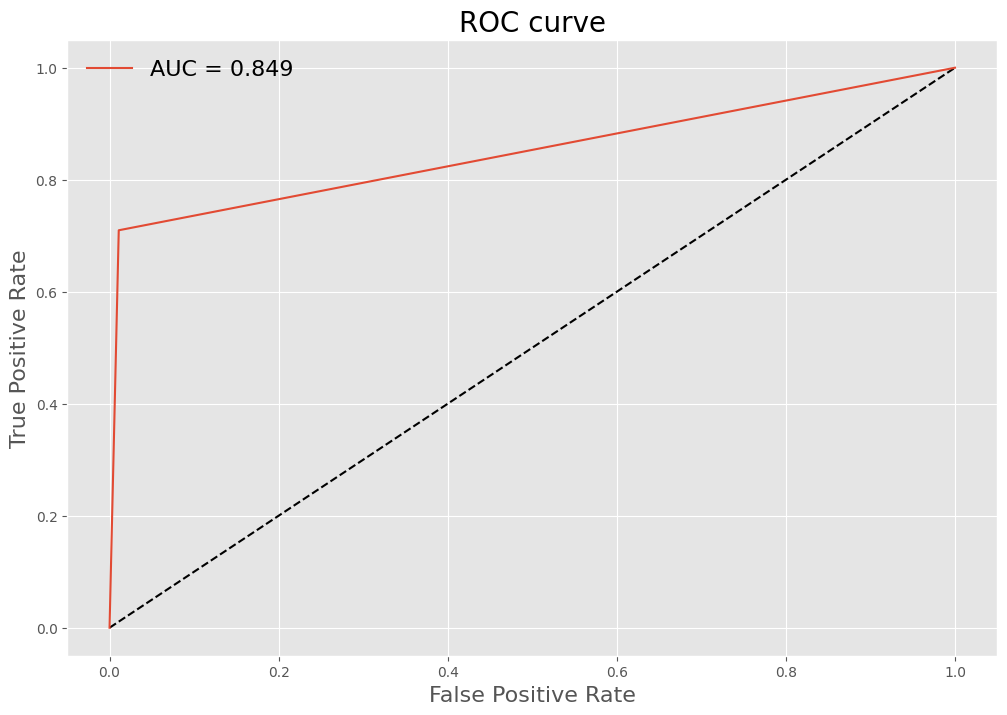

In [57]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_02)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

# Unfreezing and fine-tuning the entire network

In [58]:
# Build the network
base_model = VGG19(include_top=False, input_shape=(128,128,3))
x = base_model.output
flat=Flatten()(x)
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)
model_03 = Model(base_model.inputs, output)

# Load weights
model_03.load_weights('model_weights/vgg19_model_02.weights.h5')

sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
# Compile the model
model_03.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\divyam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [59]:
history_03 = model_03.fit(train_generator,
                          steps_per_epoch=100,
                          epochs=35,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8594 - loss: 0.3469
Epoch 1: val_loss improved from 0.26154 to 0.21315, saving model to models/malaria.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 811s 8s/step - accuracy: 0.8593 - loss: 0.3469 - val_accuracy: 0.9173 - val_loss: 0.2132 - learning_rate: 1.0000e-04
Epoch 2/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8592 - loss: 0.3247
Epoch 2: val_loss improved from 0.21315 to 0.19042, saving model to models/malaria.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 735s 7s/step - accuracy: 0.8593 - loss: 0.3246 - val_accuracy: 0.9380 - val_loss: 0.1904 - learning_rate: 1.0000e-04
Epoch 3/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8731 - loss: 0.3079
Epoch 3: val_loss did not improve from 0.19042
100/100 ━━━━━━━━━━━━━━━━━━━━ 765s 8s/step - accuracy: 0.8732 - loss: 0.3079 - val_accuracy: 0.9390 - val_loss: 0.1972 - learning_rate: 1.0000e-04
Epoch 4/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8809 - loss: 0.30

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1520.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 7: val_loss improved from 0.17130 to 0.16110, saving model to models/malaria.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 714s 7s/step - accuracy: 0.8923 - loss: 0.2721 - val_accuracy: 0.9401 - val_loss: 0.1611 - learning_rate: 1.0000e-04
Epoch 8/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8996 - loss: 0.2606
Epoch 8: val_loss improved from 0.16110 to 0.15438, saving model to models/malaria.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 727s 7s/step - accuracy: 0.8996 - loss: 0.2606 - val_accuracy: 0.9467 - val_loss: 0.1544 - learning_rate: 1.0000e-04
Epoch 9/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8891 - loss: 0.2805
Epoch 9: val_loss did not improve from 0.15438
100/100 ━━━━━━━━━━━━━━━━━━━━ 722s 7s/step - accuracy: 0.8890 - loss: 0.2805 - val_accuracy: 0.9514 - val_loss: 0.1650 - learning_rate: 1.0000e-04
Epoch 10/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9061 - loss: 0.2366
Epoch 10: val_loss improved from 0.15438 to 0.15053, saving model to models/mala

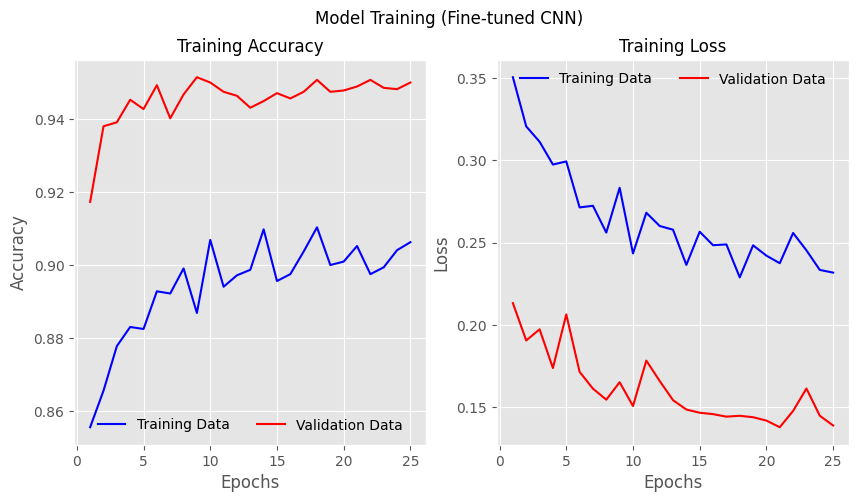

In [60]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle("Model Training (Fine-tuned CNN)", fontsize=12)
max_epoch = len(history_03.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_03.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_03.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_03.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_03.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("outputs/malaria_training_finetunedcnn.jpeg", format='jpeg', dpi=400, bbox_inches='tight')

In [61]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_03.save_weights(filepath='model_weights/vgg_unfrozen.weights.h5', overwrite=True)

# Evaluating the model

87/87 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9502 - loss: 0.1420
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 350s 127ms/step - accuracy: 0.9682 - loss: 0.1184
Validation loss     :0.1387
Validation accuracy :0.9499
Test loss           :0.1040
Test accuracy       :0.9681
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 351s 127ms/step
              precision    recall  f1-score   support

     healthy       0.97      0.97      0.97      1378
    infected       0.97      0.97      0.97      1378

    accuracy                           0.97      2756
   macro avg       0.97      0.97      0.97      2756
weighted avg       0.97      0.97      0.97      2756



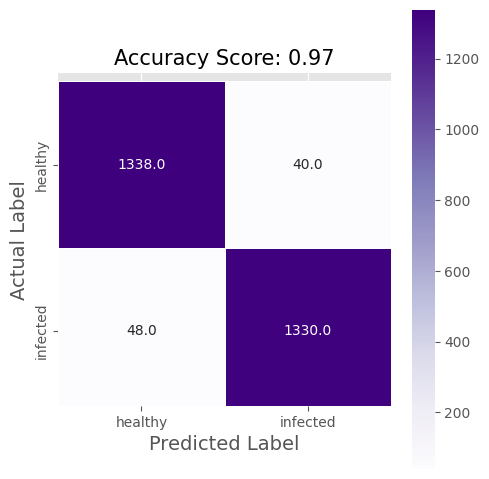

In [62]:
# Load the saved model
model_03.load_weights('model_weights/vgg_unfrozen.weights.h5')
# Evaluate the model on the hold out validation and test datasets

vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

print('Validation loss     :{0:.4f}'.format(vgg_val_eval_03[0]))
print('Validation accuracy :{0:.4f}'.format(vgg_val_eval_03[1]))
print('Test loss           :{0:.4f}'.format(vgg_test_eval_03[0]))
print('Test accuracy       :{0:.4f}'.format(vgg_test_eval_03[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_03 = model_03.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_03 = np.argmax(vgg_predictions_03, axis=1)


# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_03, 
                            target_names=['healthy', 'infected']))
vgg_conf_mat_03 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_03), 
                        index=['healthy', 'infected'], 
                        columns=['healthy', 'infected'])


fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_03, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_03[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_03)-0.05, -0.05)
plt.tight_layout()

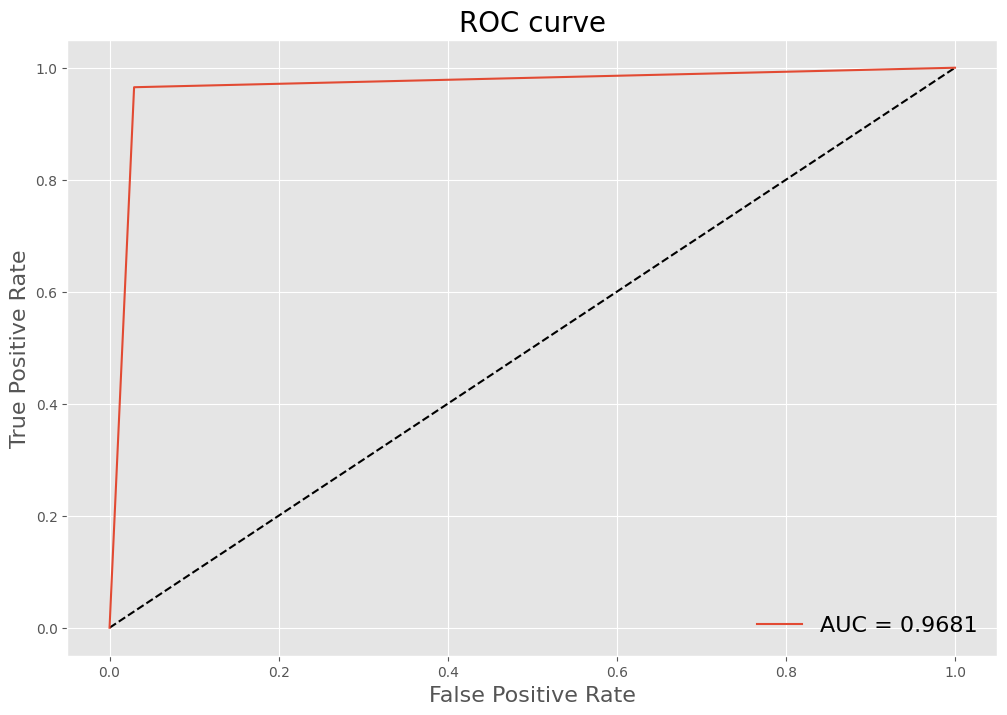

In [63]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_03)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.4f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

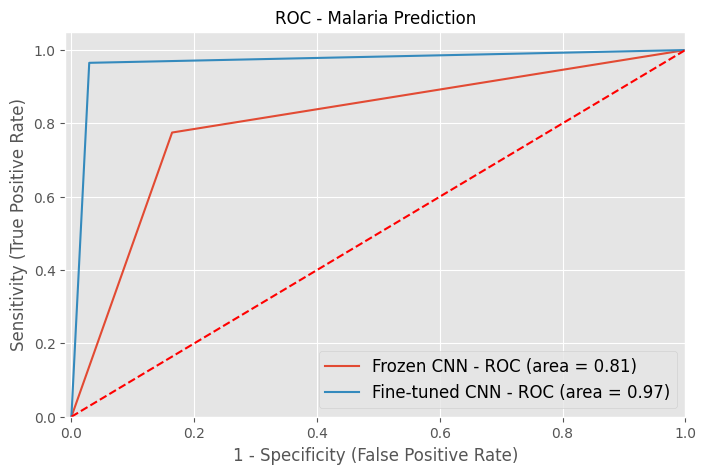

In [64]:
from sklearn import metrics
plt.figure(figsize=(8,5))
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
    'roc': vgg_pred_labels_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
    'roc': vgg_pred_labels_03,
}
]
for m in models:
    model = m['model']  
    false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, m['roc'])
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, label='%s - ROC (area = %0.2f)' % (m['label'], area_under_curve))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=12)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=12)
plt.title('ROC - Malaria Prediction', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.savefig("outputs/roc_malaria.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

[79.86, 95.65]
[79.86, 95.65]


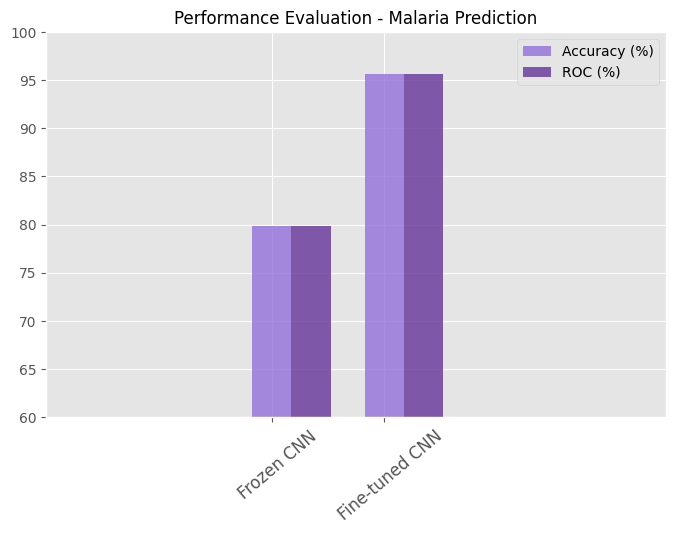

In [65]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
}
]

means_roc = [79.86, 95.65]
means_accuracy = [79.86, 95.65]
means_loss = [45.57, 12.14]

print(means_accuracy)
print(means_roc)

# data to plot
n_groups = 2
means_loss = tuple(means_loss)
means_accuracy = tuple(means_accuracy)
# means_roc = tuple(means_roc)

# create plot
fig, ax = plt.subplots(figsize=(8,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

# rects1 = plt.bar(index, means_loss, bar_width,
# alpha=opacity, 
# color='pink',
# label='Categorical crossentropy Loss (%)')

rects2 = plt.bar(index, means_accuracy, bar_width,
alpha=opacity, 
color='mediumpurple',
label='Accuracy (%)')

rects3 = plt.bar(index + bar_width, means_roc, bar_width,
alpha=opacity, 
color='rebeccapurple',
label='ROC (%)')

plt.xlim([-2, 3.5])
plt.ylim([60, 100])

plt.title('Performance Evaluation - Malaria Prediction', fontsize=12)
plt.xticks(index, ('   Frozen CNN', '   Fine-tuned CNN'), rotation=40, ha='center', fontsize=12)
plt.legend(loc="upper right", fontsize=10)
# plt.legend(bbox_to_anchor =(1, 0.6), fontsize=12)
plt.savefig("outputs/PE_malaria.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

[45.57, 12.14]


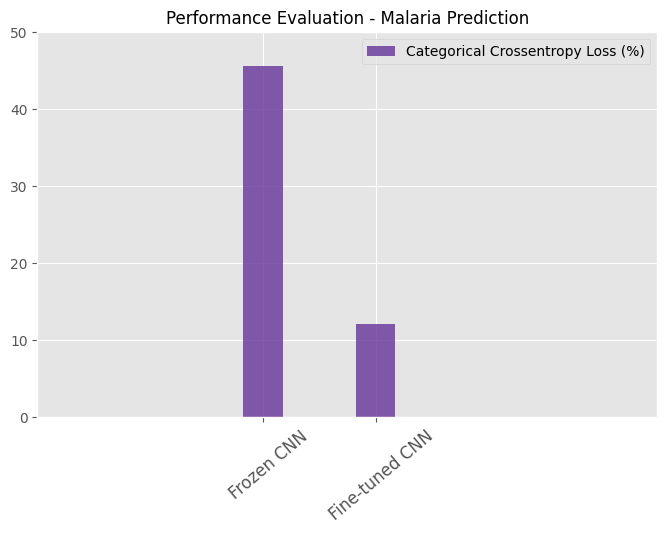

In [66]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
}
]

means_loss = [45.57, 12.14]

print(means_loss)

# data to plot
n_groups = 2
means_roc = tuple(means_roc)

# create plot
fig, ax = plt.subplots(figsize=(8,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_loss, bar_width,
alpha=opacity, 
color='rebeccapurple',
label='Categorical Crossentropy Loss (%)')

plt.xlim([-2, 3.5])
plt.ylim([0, 50])

plt.title('Performance Evaluation - Malaria Prediction', fontsize=12)
plt.xticks(index, ('   Frozen CNN', '   Fine-tuned CNN'), rotation=40, ha='center', fontsize=12)
plt.legend(loc="upper right", fontsize=10)
# plt.legend(bbox_to_anchor =(1, 0.6), fontsize=12)
plt.savefig("outputs/PE_malaria2.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

## Prediction results for 10 randomly selected images

In [67]:
test_images = [img for img in random.sample(infected_test_fpaths, 5)]
test_images.extend([img for img in random.sample(healthy_test_fpaths, 5)])

IndexError: list index out of range

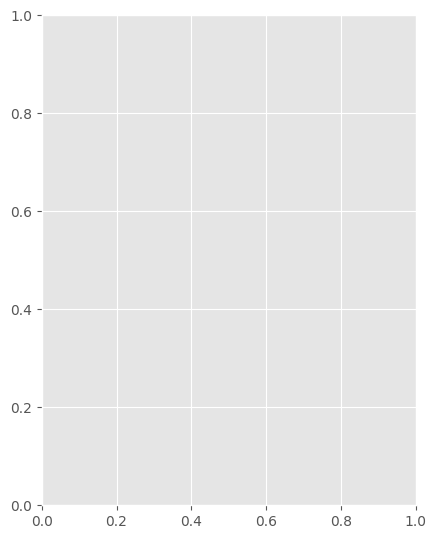

In [70]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Corrected import

true_labels = []
predicted_labels = [] 
fig = plt.figure(figsize=(28,14))
columns = 5
rows = 2

# Adjust loop to prevent accessing out of range elements
for i in range(1, min(columns * rows, len(test_images)) + 1):
    fig.add_subplot(rows, columns, i)
    
    # Store the true label
    true_label = test_images[i-1].split('/')[-2]  # Use -2 to get the label assuming it's the second last segment
    true_labels.append(true_label)
    
    # Load and display the image
    img = mpimg.imread(test_images[i-1])
    plt.imshow(img)
    plt.axis('off')
    
    # Prepare the image for prediction
    img = tf.keras.utils.load_img(test_images[i-1], target_size=(128, 128))
    img = tf.keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    
    # Predict the label
    prediction = model_03.predict(img)
    predicted_label = np.argmax(prediction)
    predicted_labels.append(predicted_label)
    
    # Display predicted and true labels
    plt.title('Predicted Label: {}\nTrue Label: {}'.format(class_names[predicted_label], true_label), fontsize=24)

# Save the figure
plt.savefig("outputs/malaria_predictions.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()
